<a href="https://colab.research.google.com/github/aryamanpathak2022/Sentimental_analysis_wn/blob/main/models/sentiment_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [4]:
!pip install vaderSentiment
!pip install textblob
!pip install flair
!pip install nltk
!pip install matplotlib




[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /root/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package subjectivity to /root/nltk_data...
[nltk_data]   Package subjectivity is already up-to-date!


  Company_name                                           Headline  \
0      nytimes  Man Accused in Plot to Assassinate Sikh Separa...   
1      nytimes  Fire in Kuwait Worker Housing Leaves at Least ...   
2      nytimes  Train Crash in India Leaves at Least 8 Dead an...   
3      nytimes  G7 Leaders, Expanding the Circle, Shift Focus ...   
4      nytimes  At the Ambani Wedding Celebrations, a Dazzling...   

            Date                                               Link  \
0  June 17, 2024  https://www.nytimes.com/2024/06/17/nyregion/ni...   
1  June 12, 2024  https://www.nytimes.com/2024/06/12/world/middl...   
2  June 17, 2024  https://www.nytimes.com/2024/06/17/world/asia/...   
3  June 14, 2024  https://www.nytimes.com/2024/06/14/world/europ...   
4  June 12, 2024  https://www.nytimes.com/2024/06/12/fashion/wed...   

                                             Article  \
0  An Indian man pleaded not guilty on Monday to ...   
1  At least 49 people were killed and dozens o

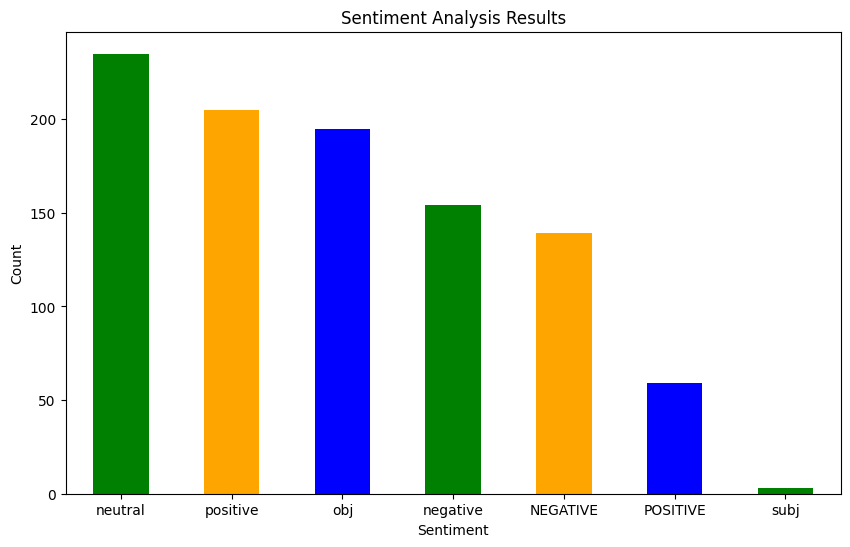

Sentiment Distribution:
neutral     235
positive    205
obj         195
negative    154
NEGATIVE    139
POSITIVE     59
subj          3
Name: count, dtype: int64


In [12]:
import pandas as pd
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import flair
from flair.models import TextClassifier
from nltk.sentiment import SentimentIntensityAnalyzer as NLTKSentimentAnalyzer
from nltk.classify import NaiveBayesClassifier
from nltk.corpus import subjectivity
import matplotlib.pyplot as plt
import nltk
import re
import random
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from flair.data import Sentence

# Ensure you have the necessary NLTK data files
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
nltk.download('vader_lexicon')
nltk.download('subjectivity')

# Load the processed data (assuming 'processed_Articles.csv' exists and has been preprocessed)
processed_df = pd.read_csv('processed_Articles.csv')

# Display the first few rows to understand the structure
print(processed_df.head())

# Initialize models
vader_analyzer = SentimentIntensityAnalyzer()
flair_sentiment_model = TextClassifier.load('en-sentiment')
nltk_sentiment_analyzer = NLTKSentimentAnalyzer()

# Function to preprocess text
def preprocess_text(text):
    text = text.lower()
    text = re.sub('[^a-z\s]', '', text)
    words = nltk.word_tokenize(text)
    stop_words = set(stopwords.words('english'))
    words = [word for word in words if word not in stop_words]
    lemmatizer = WordNetLemmatizer()
    words = [lemmatizer.lemmatize(word) for word in words]
    return ' '.join(words)

# Preprocess articles if not already preprocessed
processed_df['Processed_Article'] = processed_df['Processed_Article'].apply(preprocess_text)

# NLTK Naive Bayes classification using subjectivity dataset
def document_features(document):
    document_words = set(document)
    features = {}
    for word in document_words:
        features['contains({})'.format(word)] = True
    return features

# Load subjectivity dataset
subjectivity_docs = [(list(doc), 'subj') for doc in subjectivity.sents(categories='subj')] + \
                    [(list(doc), 'obj') for doc in subjectivity.sents(categories='obj')]

# Shuffle the dataset
random.shuffle(subjectivity_docs)

# Extract features and split into training and testing sets
featuresets = [(document_features(doc), category) for (doc, category) in subjectivity_docs]
train_set, test_set = featuresets[100:], featuresets[:100]

# Train Naive Bayes classifier
classifier = NaiveBayesClassifier.train(train_set)

# Function to perform sentiment analysis using each model
def analyze_sentiment(article):
    # VADER sentiment analysis
    vader_score = vader_analyzer.polarity_scores(article)['compound']

    # TextBlob sentiment analysis
    textblob_score = TextBlob(article).sentiment.polarity

    # Flair sentiment analysis
    sentence = Sentence(article)
    flair_sentiment_model.predict(sentence)
    flair_score = sentence.labels[0].value if sentence.labels else 'neutral'

    # NLTK sentiment analysis using Vader as an example
    nltk_vader_score = nltk_sentiment_analyzer.polarity_scores(article)['compound']

    # NLTK Naive Bayes classification
    features = document_features(article.split())
    nltk_nb_score = classifier.classify(features)

    return {
        'VADER': 'positive' if vader_score >= 0.75 else 'negative' if vader_score <= -0.75 else 'neutral',
        'TextBlob': 'positive' if textblob_score >= 0.75 else 'negative' if textblob_score <= -0.75 else 'neutral',
        'Flair': flair_score,
        'NLTK_VADER': 'positive' if nltk_vader_score >= 0.75 else 'negative' if nltk_vader_score <= -0.75 else 'neutral',
        'NLTK_NaiveBayes': nltk_nb_score
    }

# Apply sentiment analysis to each article
processed_df['sentiment'] = processed_df['Processed_Article'].apply(analyze_sentiment)

# Plot sentiment analysis results
sentiment_counts = processed_df['sentiment'].apply(pd.Series).stack().value_counts()
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind='bar', color=['green', 'orange', 'blue'])
plt.title('Sentiment Analysis Results')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.xticks(rotation=0)
plt.show()

# Display sentiment distribution
print("Sentiment Distribution:")
print(sentiment_counts)


In [14]:
print(processed_df['sentiment'])

# select whichever is maximum occurence




0      {'VADER': 'negative', 'TextBlob': 'neutral', '...
1      {'VADER': 'negative', 'TextBlob': 'neutral', '...
2      {'VADER': 'negative', 'TextBlob': 'neutral', '...
3      {'VADER': 'positive', 'TextBlob': 'neutral', '...
4      {'VADER': 'positive', 'TextBlob': 'neutral', '...
                             ...                        
193    {'VADER': 'positive', 'TextBlob': 'neutral', '...
194    {'VADER': 'neutral', 'TextBlob': 'neutral', 'F...
195    {'VADER': 'negative', 'TextBlob': 'neutral', '...
196    {'VADER': 'negative', 'TextBlob': 'neutral', '...
197    {'VADER': 'negative', 'TextBlob': 'neutral', '...
Name: sentiment, Length: 198, dtype: object


TypeError: '>=' not supported between instances of 'dict' and 'dict'

In [25]:
def remove_last_key(sentiments):
    for sentiment_list in sentiments:
        for sentiment_dict in sentiment_list:
            if sentiment_dict:
                del sentiment_dict[next(reversed(sentiment_dict))]
    return sentiments

In [28]:
type(processed_df['sentiment'])

pandas.core.series.Series

In [23]:
def majority_sentiment(sentiments):
    sentiment_count = {'positive': 0, 'neutral': 0, 'negative': 0}

    for model_sentiment in sentiments:
      print(sentiments)
    #     for model, sentiment in model_sentiment.items():
    #         if sentiment in sentiment_count:
    #             sentiment_count[sentiment] += 1

    # max_sentiment = max(sentiment_count, key=sentiment_count.get)
    # return max_sentiment


In [24]:



processed_df['max_sentiment'] = processed_df['sentiment'].apply(majority_sentiment)
print(processed_df['max_sentiment'])

{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'NEGATIVE', 'NLTK_VADER': 'negative', 'NLTK_NaiveBayes': 'obj'}
{'VADER': 'negative', 'TextBlob': 'neutral', 'Flair': 'N